### KDD 2022 Hands-on Tutorial on "Gradual AutoML using Lale"

# 5. Bias Mitigation

Datasets and predictive models can exhibit bias, which means they are
unfair against certain groups or individuals.
We would of course like to avoid that when possible.
Mitigating bias cannot be solved by data scientists alone; it requires
a discussion with more stake-holders, for instance, to determine what
bias to target and how to measure it.
That said, there are algorithmic bias mitigation techniques that can
contribute to a solution.
This notebook presents some fairness metrics and bias mitigators
distributed with Lale, and shows how to use them either with manual
machine learning or with AutoML.

This notebook has the following sections:

- [5.1 Datasets and Fairness Information](#5.1-Dataset-and-Fairness-Information)
- [5.2 Metrics](#5.2-Metrics)
- [5.3 Non-Mitigated Pipeline](#5.3-Non-Mitigated-Pipeline)
- [5.4 Mitigators](#5.4-Mitigators)
- [5.5 AutoML with Mitigators](#5.5-AutoML-with-Mitigators)

## 5.1 Dataset and Fairness Information

Like other notebooks in this tutorial, this notebook uses the
[credit-g](https://www.openml.org/search?type=data&status=active&id=31)
dataset from OpenML.
First, we import the Lale wrappers for
[AIF360](https://aif360.mybluemix.net/).

In [1]:
import lale.lib.aif360 as lf

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'


In [2]:
try:
    import lale.lib.aif360 as lf
except UnicodeWarning:
    warnings.warn('Oh Non', stacklevel=2)

Depending on your Python environment, the above imports may yield some
warnings about missing tensorflow or numba; you can ignore those,
since this notebook does not need those packages.
Next, we fetch the dataset along with its `fairness_info`.

In [3]:
X, y, fairness_info = lf.fetch_creditg_df()
fairness_info

{'favorable_labels': ['good'],
 'protected_attributes': [{'feature': 'personal_status',
   'reference_group': ['male div/sep', 'male mar/wid', 'male single']},
  {'feature': 'age', 'reference_group': [[26, 1000]]}]}

The `fairness_info` is a Python dictionary of fairness-related
meta-data about the dataset.
It tells us which labels in `y` indicate a favorable outcome.
Furthermore, it tells us which columns in `X` are protected
attributes, i.e., features whose value indicates membership in
a privileged group, and what those values are.
To make this concrete, let's look at the dataset.

In [4]:
import pandas as pd
pd.options.display.max_rows = 10
pd.options.display.max_columns = None
pd.concat([y, X], axis=1)

,class,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,good,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,4.0,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes
1,bad,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,2.0,real estate,22.0,none,own,1.0,skilled,1.0,none,yes
2,good,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,3.0,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes
3,good,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,4.0,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes
4,bad,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,4.0,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,good,no checking,12.0,existing paid,furniture/equipment,1736.0,<100,4<=X<7,3.0,female div/dep/mar,none,4.0,real estate,31.0,none,own,1.0,unskilled resident,1.0,none,yes
996,good,<0,30.0,existing paid,used car,3857.0,<100,1<=X<4,4.0,male div/sep,none,4.0,life insurance,40.0,none,own,1.0,high qualif/self emp/mgmt,1.0,yes,yes
997,good,no checking,12.0,existing paid,radio/tv,804.0,<100,>=7,4.0,male single,none,4.0,car,38.0,none,own,1.0,skilled,1.0,none,yes
998,bad,<0,45.0,existing paid,radio/tv,1845.0,<100,1<=X<4,4.0,male single,none,4.0,no known property,23.0,none,for free,1.0,skilled,1.0,yes,yes


There are two labels, `class='good'` and `class='bad'`.

favorable: ['good']


<AxesSubplot: >

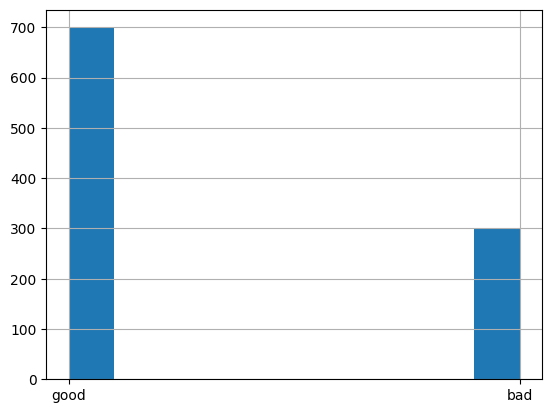

In [5]:
print(f"favorable: {fairness_info['favorable_labels']}")
y.hist()

The `fairness_info` tells us that `'good'` is in `favorable_labels`.

first protected attribute: {'feature': 'personal_status', 'reference_group': ['male div/sep', 'male mar/wid', 'male single']}


<AxesSubplot: >

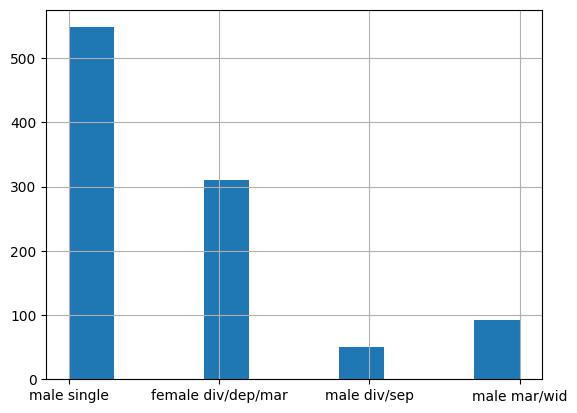

In [6]:
print(f"first protected attribute: {fairness_info['protected_attributes'][0]}")
X["personal_status"].hist()

The `fairness_info` tells us that one of the
`protected_attributes` is `personal_status`, and that values
in `['male div/sep', 'male mar/wid', 'male single']`
indicate members of the privileged group.

second protected attribute: {'feature': 'age', 'reference_group': [[26, 1000]]}


<AxesSubplot: >

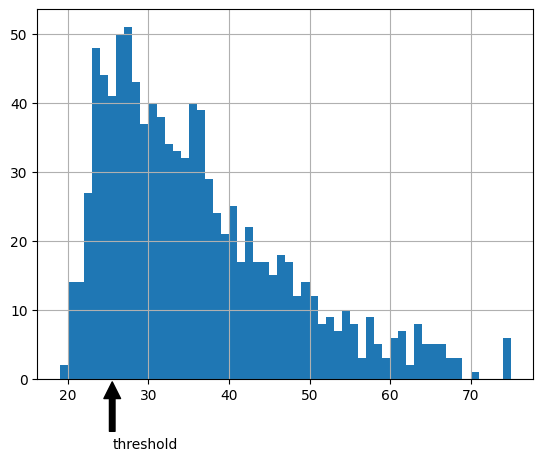

In [7]:
print(f"second protected attribute: {fairness_info['protected_attributes'][1]}")
ax = X.age.hist(bins=range(int(X.age.min()), int(X.age.max()) + 1))
ax.annotate("threshold", xy=(25.5, 0), xytext=(25.5, -10),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax

The `fairness_info` tells us that another one of the
`protected_attributes` is `age`, and that values in the range
`[26, 1000]` indicate members of the privileged group.
To understand the overall distribution of data rows by positive
outcomes and membership in the privileged group for each attribute, we
can use the helper function `count_fairness_groups`.

In [8]:
lf.count_fairness_groups(X, y, **fairness_info)

count     ratio
y_true personal_status age                 
0      0               0       47  0.447619
                       1       62  0.302439
       1               0       33  0.388235
                       1      158  0.261157
1      0               0       58  0.552381
                       1      143  0.697561
       1               0       52  0.611765
                       1      447  0.738843

For example, for `y_true 0` (unfavorable outcome), `personal_status 0`
(unprivileged gender), and `age 0` (unprivileged age), the dataset
contains 47 samples.
In contrast, for `y_true 1` (favorable outcome), `personal_status 0`
(unprivileged gender), and `age 0` (unprivileged age), the dataset
contains 58 samples.
That means that among young females, the ratio of favorable outcomes is
58 / (47 + 58) = 0.552, which is a worse ratio than for other groups.

##  5.2 Metrics

Lale provides several [fairness metrics](https://lale.readthedocs.io/en/latest/modules/lale.lib.aif360.html#metrics) from AIF360.
Which metric to choose depends on the values and policies of you and
your organization.
For illustration purposes, this notebook demonstrates
[disparate impact](https://doi.org/10.1145/2783258.2783311).
We first configure it with the `fairness_info`, then use it to score
the dataset.

In [9]:
di_scorer = lf.disparate_impact(**fairness_info)
print(f"disparate impact {di_scorer.score_data(X=X, y_pred=y):.2f}")

disparate impact 0.75


A score of 0.75 means that members of the unprivileged group
experience a positive outcome only 75% as often as members of the
privileged group.
This is unfair; for instance, it falls short of the 80% rule in US Law.
We can train a model that has less bias than the dataset.
For instance, a [DummyClassifier](https://lale.readthedocs.io/en/latest/modules/lale.lib.sklearn.dummy_classifier.html#lale.lib.sklearn.dummy_classifier.DummyClassifier)
ignores its input and always returns the majority label.

In [10]:
from lale.lib.sklearn import DummyClassifier
trained_dummy = DummyClassifier().fit(X, y)
print(f"dummy DI {di_scorer(trained_dummy, X, y):.2f}")
print(list(trained_dummy.predict(X))[:24])

dummy DI 1.00
['good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good']


The `DummyClassifier` is trivially perfectly fair: irrespective of
whether or not an individual is a member of the privileged group, the
predicted label is always `'good'`.
On the other hand, it is poor at predicting the ground truth labels.
To better evaluate `DummyClassifier` as well as other models, we
create a few more metrics directly from scikit-learn.

In [11]:
import sklearn.metrics
acc_scorer = sklearn.metrics.make_scorer(sklearn.metrics.accuracy_score)
rc0_scorer = sklearn.metrics.make_scorer(sklearn.metrics.recall_score, pos_label="bad")
rc1_scorer = sklearn.metrics.make_scorer(sklearn.metrics.recall_score, pos_label="good")
bal_scorer = sklearn.metrics.make_scorer(sklearn.metrics.balanced_accuracy_score)

Next, we define a utility function `get_metrics` that uses
cross-validation to evaluate a given estimator against a variety of
metrics.
For better stability, we are using a cross-validation split that
stratifies the data by both fairness outcomes and groups.

In [12]:
from sklearn.model_selection import cross_validate
fair_cv = lf.FairStratifiedKFold(**fairness_info, n_splits=3)

def get_metrics(estimator):
    scores = cross_validate(estimator, X, y, cv=fair_cv, scoring={
        "disparate impact": di_scorer,
        "balanced accuracy": bal_scorer,
        "recall (unfavorable)": rc0_scorer,
        "recall (favorable)": rc1_scorer,
        "accuracy": acc_scorer,
    })
    result = pd.DataFrame.from_dict(scores)
    mean, std = result.mean(), result.std()
    result.loc["mean"] = mean
    result.loc["std"] = std
    return result

pd.options.display.float_format = "{:.2f}".format

Let's look at all these metrics for `DummyClassifier` as a baseline.

In [13]:
get_metrics(trained_dummy)

,fit_time,score_time,test_disparate impact,test_balanced accuracy,test_recall (unfavorable),test_recall (favorable),test_accuracy
0,0.00,0.03,1.00,0.50,0.00,1.00,0.70
1,0.00,0.03,1.00,0.50,0.00,1.00,0.70
2,0.00,0.05,1.00,0.50,0.00,1.00,0.70
mean,0.00,0.04,1.00,0.50,0.00,1.00,0.70
std,0.00,0.01,0.00,0.00,0.00,0.00,0.00


Rows `0`, `1`, and `2` represent the three cross-validation folds, and
the rows `mean` and `std` show their average and standard deviation.
Columns `fit_time` and `score_time` show that `DummyClassifier` is
fast, which is no surprise.
We already knew that its disparate impact is 1.00, so it is
perfectly fair.
Its balanced accuracy (across positive and negative outcomes) is
0.50, because it has a recall of 0.00 for unfavorable labels and a
recall of 1.00 for favorable labels.
Finally, its accuracy is 0.70, because the dataset is imbalanced,
with 70% of instances having positive outcomes.

## 5.3 Non-Mitigated Pipeline

How well does a simple pipeline perform on this dataset if it does not
use any algorithmic bias mitigators?
First, let's create a preprocessing sub-pipeline to ensure all columns are
numeric.

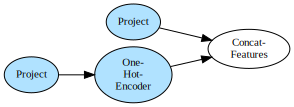

In [14]:
from lale.lib.lale import Project, ConcatFeatures
from lale.lib.sklearn import OneHotEncoder, MinMaxScaler

prefix = (
    Project(columns={"type": "number"})
    & (
        Project(drop_columns={"type": "number"})
        >> OneHotEncoder(handle_unknown="ignore")
    )
) >> ConcatFeatures
prefix.visualize()

Next, let's add a random forest classifier as the final estimator to
this pipeline and evaluate its performance.

In [15]:
from lale.lib.sklearn import RandomForestClassifier
trainable_nomit = prefix >> RandomForestClassifier()
get_metrics(trainable_nomit)

,fit_time,score_time,test_disparate impact,test_balanced accuracy,test_recall (unfavorable),test_recall (favorable),test_accuracy
0,0.34,0.12,0.73,0.66,0.42,0.89,0.75
1,0.51,0.09,0.64,0.67,0.38,0.96,0.78
2,0.38,0.10,0.79,0.68,0.44,0.91,0.77
mean,0.41,0.10,0.72,0.67,0.41,0.92,0.77
std,0.09,0.02,0.07,0.01,0.03,0.03,0.02


Compared to the `DummyClassifier`, the `RandomForestClassifier` has
worse fairness but better predictive performance, as expected.

## 5.4 Mitigators

Lale provides several [bias mitigators](https://lale.readthedocs.io/en/latest/modules/lale.lib.aif360.html#pre-estimator-mitigation-operators) from AIF360.
This notebook demonstrates three representative ones.
The first one, [GerryFairClassifier](https://lale.readthedocs.io/en/latest/modules/lale.lib.aif360.gerry_fair_classifier.html#lale.lib.aif360.gerry_fair_classifier.GerryFairClassifier),
is an in-estimator mitigator, meaning that it has its own built-in estimator.
We configure it with the previously defined `fairness_info` and
`prefix`, which is a data preparation sub-pipeline.

In [16]:
from lale.lib.aif360 import GerryFairClassifier as InMit
trainable_inmit = InMit(**fairness_info, preparation=prefix)
get_metrics(trainable_inmit)

,fit_time,score_time,test_disparate impact,test_balanced accuracy,test_recall (unfavorable),test_recall (favorable),test_accuracy
0,1.92,0.45,0.76,0.74,0.71,0.76,0.75
1,0.74,0.30,0.63,0.65,0.40,0.90,0.75
2,1.22,0.29,0.64,0.70,0.52,0.88,0.77
mean,1.29,0.35,0.68,0.70,0.54,0.85,0.76
std,0.59,0.09,0.07,0.04,0.16,0.07,0.01


The second example, [DisparateImpactRemover](https://lale.readthedocs.io/en/latest/modules/lale.lib.aif360.disparate_impact_remover.html#lale.lib.aif360.disparate_impact_remover.DisparateImpactRemover),
is a pre-estimator mitigator, meaning that it transforms the data to
make it more fair before it is piped to an estimator.

In [17]:
from lale.lib.aif360 import DisparateImpactRemover as PreMit
trainable_premit = PreMit(**fairness_info, preparation=prefix) >> RandomForestClassifier()
get_metrics(trainable_premit)

,fit_time,score_time,test_disparate impact,test_balanced accuracy,test_recall (unfavorable),test_recall (favorable),test_accuracy
0,0.59,0.22,1.00,0.68,0.44,0.91,0.77
1,0.62,0.24,0.87,0.64,0.34,0.94,0.76
2,0.54,0.26,0.93,0.68,0.42,0.94,0.78
mean,0.58,0.24,0.93,0.66,0.40,0.93,0.77
std,0.04,0.02,0.06,0.02,0.05,0.01,0.01


The third example, [CalibratedEqOddsPostprocessing](https://lale.readthedocs.io/en/latest/modules/lale.lib.aif360.calibrated_eq_odds_postprocessing.html#lale.lib.aif360.calibrated_eq_odds_postprocessing.CalibratedEqOddsPostprocessing),
is a post-estimator mitigator, meaning that it transforms the predictions
after they are returned from an estimator.

In [18]:
from lale.lib.aif360 import CalibratedEqOddsPostprocessing as PostMit
trainable_postmit = PostMit(**fairness_info, estimator=prefix >> RandomForestClassifier())
get_metrics(trainable_postmit)

,fit_time,score_time,test_disparate impact,test_balanced accuracy,test_recall (unfavorable),test_recall (favorable),test_accuracy
0,0.47,0.27,0.86,0.62,0.57,0.67,0.64
1,0.63,0.19,0.82,0.61,0.55,0.67,0.63
2,0.47,0.21,0.83,0.60,0.52,0.68,0.63
mean,0.52,0.22,0.84,0.61,0.55,0.67,0.63
std,0.09,0.04,0.02,0.01,0.03,0.00,0.01


Overall, the three demonstrated mitigators vary in their effectiveness
at mitigating bias for this particular dataset and in the predictive
performance of the mitigated pipeline.

## 5.5 AutoML with Mitigators

We can create a search space with a choice of mitigated pipelines by
simply using Lale's or-combinator (`|`).

In [19]:
planned_mit3 = trainable_inmit | trainable_premit | trainable_postmit

Next, we can use `auto_configure` to run AutoML on this search space.
This will not just tweak the algorithm choices but also tune
hyperparameters, including those of mitigators.
As the optimization objective, we use a combined scorer that lets
AutoML optimize for both balanced accuracy (for predictive
performance) and disparate impact (for fairness).

In [20]:
%%time
from lale.lib.lale import Hyperopt
comb_scorer = lf.balanced_accuracy_and_disparate_impact(**fairness_info)
trained_mit3 = planned_mit3.auto_configure(
    X, y, optimizer=Hyperopt, max_evals=5, cv=fair_cv, scoring=comb_scorer
)

100%|██████████| 5/5 [00:12<00:00,  2.46s/trial, best loss: -0.7614278773442624]
CPU times: user 15.6 s, sys: 10.4 s, total: 26 s
Wall time: 13.4 s


We can visualize the best (with respect to the combined scorer)
pipeline AutoML encountered in its trials, and we can look at its
metrics.

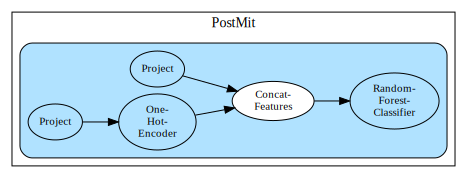

,fit_time,score_time,test_disparate impact,test_balanced accuracy,test_recall (unfavorable),test_recall (favorable),test_accuracy
0,0.52,0.20,0.99,0.57,0.46,0.68,0.61
1,0.37,0.23,1.05,0.55,0.40,0.70,0.61
2,0.47,0.16,1.08,0.58,0.46,0.69,0.62
mean,0.45,0.20,1.04,0.56,0.44,0.69,0.61
std,0.07,0.04,0.05,0.01,0.03,0.01,0.01


In [21]:
trained_mit3.visualize()
get_metrics(trained_mit3)

In this example, the result prioritized fairness over predictive
performance, performing only slightly better than `DummyClassifier`.
You can experiment with a higher `max_evals` and/or different search
objectives.

The following papers provide more information on fairness support in
Lale:

```bibtex
@InProceedings{feffer_et_al_2022,
  title = "An Empirical Study of Modular Bias Mitigators and Ensembles",
  author = "Feffer, Michael and Hirzel, Martin and Hoffman, Samuel C. and Kate, Kiran and Ram, Parikshit and Shinnar, Avraham",
  booktitle = "Workshop on Benchmarking Data for Data-Centric AI (DataPerf@ICML)",
  year = 2022,
  month = jul,
  url = "http://hirzels.com/martin/papers/dataperf22-fair-ensembles.pdf" }
```

```bibtex
@InProceedings{hirzel_kate_ram_2021,
  title = "Engineering Fair Machine Learning Pipelines",
  author = "Hirzel, Martin and Kate, Kiran and Ram, Parikshit",
  booktitle = "ICLR Workshop on Responsible AI (RAI@ICLR)",
  year = 2021,
  month = may,
  url = "http://hirzels.com/martin/papers/rai21-fairness.pdf" }
```